# 1. **🛠️ Preparación de los Datos**


#**Preparar los datos para el modelado (tratamiento, codificación, normalización).**





In [ ]:
# Importar librerías

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
# Cargar los datos
df = pd.read_csv(
    "https://raw.githubusercontent.com/mateo16dev/Telecom-X-2da-Parte/refs/heads/main/Archivos%20An%C3%A1lisis/TelecomX_Procesado.csv",
    encoding="utf-8-sig"
)


In [ ]:
# Separar X (features) e y (target)
X = df.drop("Churn", axis=1)   # Variables independientes
y = df["Churn"]                # Variable objetivo

# Identificar variables categóricas y numéricas
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("Variables categóricas:", cat_cols)
print("Variables numéricas:", num_cols)

Variables categóricas: ['gender', 'Partner', 'Dependents', 'customerID', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
Variables numéricas: ['SeniorCitizen', 'tenure', 'Charges.Monthly', 'Charges.Total', 'Cuentas_Diarias']


## Encoding

In [ ]:
# Preprocesamiento con ColumnTransformer
# - OneHotEncoder para categóricas
# - StandardScaler para numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

#Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Aplicar preprocesamiento
# Creamos un pipeline que aplique el preprocesamiento
pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

# Transformar los datos
X_train_prep = pipeline.fit_transform(X_train)
X_test_prep = pipeline.transform(X_test)

print("Shape X_train original:", X_train.shape)
print("Shape X_train procesado:", X_train_prep.shape)

Shape X_train original: (5634, 21)
Shape X_train procesado: (5634, 5680)


## Verificación de la Proporción de Cancelación (Churn)

In [ ]:
# Contar clientes por cada categoría de Churn
churn_counts = df['Churn'].value_counts()

# Calcular proporción
churn_proportion = df['Churn'].value_counts(normalize=True)

print("Conteo de clientes por Churn:\n", churn_counts)
print("\nProporción de clientes por Churn:\n", churn_proportion)


Conteo de clientes por Churn:
 Churn
No     5174
Yes    1869
Name: count, dtype: int64

Proporción de clientes por Churn:
 Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


In [ ]:
from sklearn.pipeline import Pipeline

full_pipeline = Pipeline(steps=[
    ('preprocessor', pipeline),   # pipeline es el ColumnTransformer
    # ('clf', modelo)  # si agregas un clasificador
])

In [ ]:
# Ajustar el pipeline y transformar los datos
X_train_prep = full_pipeline.fit_transform(X_train)
X_test_prep  = full_pipeline.transform(X_test)

# Ahora X_train_prep y X_test_prep están normalizados y codificados
print("Shape X_train procesado:", X_train_prep.shape)
print("Shape X_test procesado:", X_test_prep.shape)


Shape X_train procesado: (5634, 5680)
Shape X_test procesado: (1409, 5680)


## Eliminar columnas innecesarias

In [ ]:
drop_cols = ['customerID']
df_model = df.drop(columns=drop_cols)

# Separar X (features) e y (target)
X = df_model.drop("Churn", axis=1)
y = df_model["Churn"]

# dentificar variables categóricas y numéricas
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("Variables categóricas:", categorical_cols)
print("Variables numéricas:", numeric_cols)


Variables categóricas: ['gender', 'Partner', 'Dependents', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
Variables numéricas: ['SeniorCitizen', 'tenure', 'Charges.Monthly', 'Charges.Total', 'Cuentas_Diarias']


# 2. **🎯 Correlación y Selección de Variables**

## **Realizar análisis de correlación y selección de variables.**

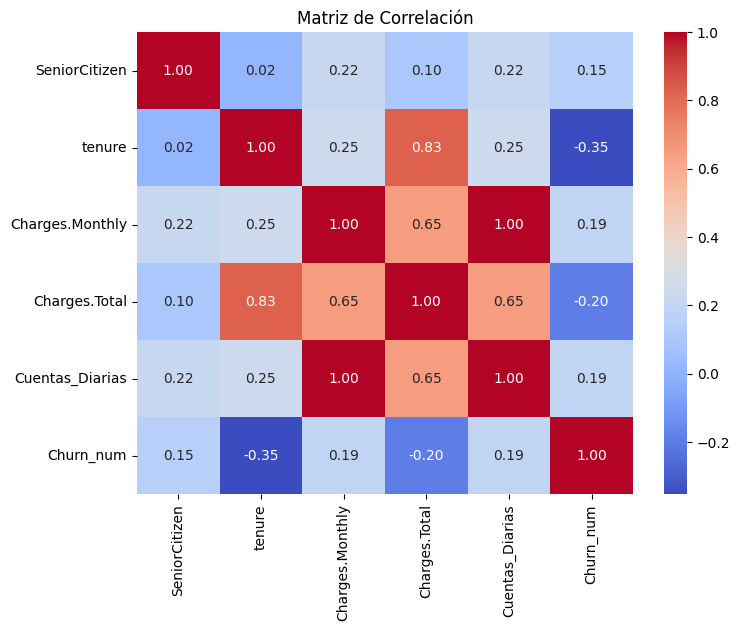

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convertimos Churn a 0 y 1
df_corr = df_model.copy()
df_corr['Churn_num'] = df_corr['Churn'].map({'No':0, 'Yes':1})

# Seleccionamos solo variables numéricas + Churn
num_cols_for_corr = numeric_cols + ['Churn_num']
corr_matrix = df_corr[num_cols_for_corr].corr()

# Visualización
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de Correlación")
plt.show()


In [ ]:
# Correlación con Churn
corr_target = corr_matrix['Churn_num'].drop('Churn_num')
print("Correlación con Churn:\n", corr_target)

# Variables con correlación > 0.1 o < -0.1 (ajustable)
selected_features_corr = corr_target[abs(corr_target) > 0.1].index.tolist()
print("\nVariables seleccionadas por correlación:", selected_features_corr)


Correlación con Churn:
 SeniorCitizen      0.150889
tenure            -0.352229
Charges.Monthly    0.193356
Charges.Total     -0.198324
Cuentas_Diarias    0.193356
Name: Churn_num, dtype: float64

Variables seleccionadas por correlación: ['SeniorCitizen', 'tenure', 'Charges.Monthly', 'Charges.Total', 'Cuentas_Diarias']


## Análisis Dirigido

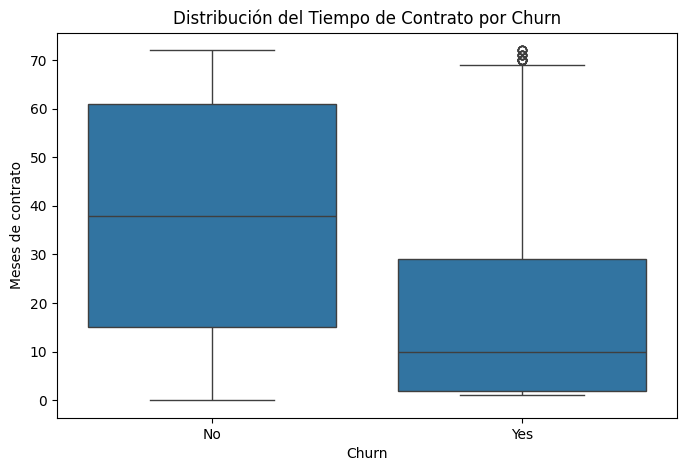

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(x='Churn', y='tenure', data=df_model)
plt.title('Distribución del Tiempo de Contrato por Churn')
plt.ylabel('Meses de contrato')
plt.show()


# 3. **🤖 Modelado Predictivo**

# Separación de Datos

In [ ]:
from sklearn.model_selection import train_test_split

# Separar features y target
X = df_model.drop("Churn", axis=1)
y = df_model["Churn"]

# División 70% entrenamiento / 30% prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # Mantiene la proporción de Churn en ambos conjuntos
)

# Verificar tamaños
print("Tamaño X_train:", X_train.shape)
print("Tamaño X_test:", X_test.shape)
print("Proporción de Churn en train:\n", y_train.value_counts(normalize=True))
print("Proporción de Churn en test:\n", y_test.value_counts(normalize=True))


Tamaño X_train: (4930, 20)
Tamaño X_test: (2113, 20)
Proporción de Churn en train:
 Churn
No     0.734686
Yes    0.265314
Name: proportion, dtype: float64
Proporción de Churn en test:
 Churn
No     0.734501
Yes    0.265499
Name: proportion, dtype: float64


#**Entrenar dos o más modelos de clasificación.**

### Regresión Logística

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Redefinir cat_cols y num_cols usando X_train después de eliminar 'customerID'
cat_cols_train = X_train.select_dtypes(include=["object"]).columns.tolist()
num_cols_train = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()


# Crear el preprocesador con las listas de columnas actualizadas
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols_train),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols_train)
    ]
)

# Crear el pipeline completo: preprocesador + modelo
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Entrenar el modelo
logreg_pipeline.fit(X_train, y_train)

# Predicciones
y_pred_train = logreg_pipeline.predict(X_train)
y_pred_test  = logreg_pipeline.predict(X_test)

# Evaluación en entrenamiento
print("=== Evaluación en TRAIN ===")
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_train))
print("Classification Report:\n", classification_report(y_train, y_pred_train))

# Evaluación en prueba
print("\n=== Evaluación en TEST ===")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

=== Evaluación en TRAIN ===
Accuracy: 0.8097363083164301
Confusion Matrix:
 [[3256  366]
 [ 572  736]]
Classification Report:
               precision    recall  f1-score   support

          No       0.85      0.90      0.87      3622
         Yes       0.67      0.56      0.61      1308

    accuracy                           0.81      4930
   macro avg       0.76      0.73      0.74      4930
weighted avg       0.80      0.81      0.80      4930


=== Evaluación en TEST ===
Accuracy: 0.7974443918599148
Confusion Matrix:
 [[1378  174]
 [ 254  307]]
Classification Report:
               precision    recall  f1-score   support

          No       0.84      0.89      0.87      1552
         Yes       0.64      0.55      0.59       561

    accuracy                           0.80      2113
   macro avg       0.74      0.72      0.73      2113
weighted avg       0.79      0.80      0.79      2113



### Modelo usando Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Redefinir cat_cols y num_cols usando X_train después de eliminar 'customerID'
# Estas listas se definieron correctamente en la celda anterior (Regresión Logística)
cat_cols_train = X_train.select_dtypes(include=["object"]).columns.tolist()
num_cols_train = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()


# Crea el preprocesador con las listas de columnas actualizadas.
preprocessor_rf = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols_train),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols_train)
    ]
)


# Crear pipeline completo: preprocesamiento + Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_rf),  # Use the newly defined preprocessor
    ('classifier', RandomForestClassifier(
        n_estimators=200,       # número de árboles
        max_depth=None,         # profundidad ilimitada
        random_state=42,
        class_weight='balanced' # balancea automáticamente las clases
    ))
])

# Entrenar el modelo
rf_pipeline.fit(X_train, y_train)

# Predicciones
y_pred_train_rf = rf_pipeline.predict(X_train)
y_pred_test_rf  = rf_pipeline.predict(X_test)

# Evaluación en entrenamiento
print("=== Evaluación Random Forest en TRAIN ===")
print("Accuracy:", accuracy_score(y_train, y_pred_train_rf))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_train_rf))
print("Classification Report:\n", classification_report(y_train, y_pred_train_rf))

# Evaluación en prueba
print("\n=== Evaluación Random Forest en TEST ===")
print("Accuracy:", accuracy_score(y_test, y_pred_test_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_test_rf))

=== Evaluación Random Forest en TRAIN ===
Accuracy: 0.9977687626774848
Confusion Matrix:
 [[3613    9]
 [   2 1306]]
Classification Report:
               precision    recall  f1-score   support

          No       1.00      1.00      1.00      3622
         Yes       0.99      1.00      1.00      1308

    accuracy                           1.00      4930
   macro avg       1.00      1.00      1.00      4930
weighted avg       1.00      1.00      1.00      4930


=== Evaluación Random Forest en TEST ===
Accuracy: 0.780407004259347
Confusion Matrix:
 [[1382  170]
 [ 294  267]]
Classification Report:
               precision    recall  f1-score   support

          No       0.82      0.89      0.86      1552
         Yes       0.61      0.48      0.54       561

    accuracy                           0.78      2113
   macro avg       0.72      0.68      0.70      2113
weighted avg       0.77      0.78      0.77      2113



# **Evaluar el rendimiento de los modelos con métricas.**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Crear diccionarios para almacenar métricas
metrics = {}

# Lista de modelos y sus predicciones
modelos = {
    "Regresión Logística": (y_pred_test, y_pred_train),
    "Random Forest": (y_pred_test_rf, y_pred_train_rf)
}

for nombre, (y_test_pred, y_train_pred) in modelos.items():
    metrics[nombre] = {}

    # Accuracy
    metrics[nombre]["Accuracy Test"] = accuracy_score(y_test, y_test_pred)
    metrics[nombre]["Accuracy Train"] = accuracy_score(y_train, y_train_pred)

    # Precisión, Recall, F1-score para cada clase
    metrics[nombre]["Precision Test"] = precision_score(y_test, y_test_pred, pos_label='Yes')
    metrics[nombre]["Recall Test"] = recall_score(y_test, y_test_pred, pos_label='Yes')
    metrics[nombre]["F1-score Test"] = f1_score(y_test, y_test_pred, pos_label='Yes')

    metrics[nombre]["Precision Train"] = precision_score(y_train, y_train_pred, pos_label='Yes')
    metrics[nombre]["Recall Train"] = recall_score(y_train, y_train_pred, pos_label='Yes')
    metrics[nombre]["F1-score Train"] = f1_score(y_train, y_train_pred, pos_label='Yes')

    # Matriz de confusión
    metrics[nombre]["Confusion Matrix Test"] = confusion_matrix(y_test, y_test_pred)
    metrics[nombre]["Confusion Matrix Train"] = confusion_matrix(y_train, y_train_pred)

# Mostrar métricas
for nombre, m in metrics.items():
    print(f"\n=== Métricas {nombre} ===")
    print(f"Accuracy Test: {m['Accuracy Test']:.4f}, Accuracy Train: {m['Accuracy Train']:.4f}")
    print(f"Precision Test: {m['Precision Test']:.4f}, Recall Test: {m['Recall Test']:.4f}, F1-score Test: {m['F1-score Test']:.4f}")
    print("Confusion Matrix Test:\n", m["Confusion Matrix Test"])



=== Métricas Regresión Logística ===
Accuracy Test: 0.7974, Accuracy Train: 0.8097
Precision Test: 0.6383, Recall Test: 0.5472, F1-score Test: 0.5893
Confusion Matrix Test:
 [[1378  174]
 [ 254  307]]

=== Métricas Random Forest ===
Accuracy Test: 0.7804, Accuracy Train: 0.9978
Precision Test: 0.6110, Recall Test: 0.4759, F1-score Test: 0.5351
Confusion Matrix Test:
 [[1382  170]
 [ 294  267]]


#**Interpretar los resultados, incluyendo la importancia de las variables.**

**Comparación de modelos para predicción de Churn**

Regresión Logística:

* Accuracy en test: 79,7%

* Recall en clientes que cancelan: 54,7%

* F1-score: 58,9%

Desempeño estable y balanceado. Detecta mejor a los clientes que realmente cancelan.

Random Forest:

* Accuracy en test: 78,0%

* Recall en clientes que cancelan: 47,6%

* F1-score: 53,5%

Presenta overfitting (accuracy train ≈ 99,8%), lo que indica que el modelo aprende demasiado de los datos de entrenamiento y no generaliza bien.

**Análisis crítico:**

El mejor desempeño lo tiene la Regresión Logística, especialmente en la detección de clientes que cancelan.

El Random Forest muestra overfitting, probablemente por exceso de árboles y profundidad ilimitada. Ajustar max_depth, min_samples_leaf o usar balanceo más avanzado podría mejorar la generalización.

Ningún modelo presenta underfitting; ambos capturan tendencias relevantes, pero el Random Forest necesita regularización para evitar sobreajuste.

**Conclusión:** Para este conjunto de datos y objetivo de detectar cancelaciones, la Regresión Logística es más confiable y estable.

# **Crear una conclusión estratégica señalando los principales factores que influyen en la cancelación.**



**Conclusión Estratégica sobre Churn**

* Tiempo de contrato (tenure):

  Clientes con menor tiempo de permanencia tienen mayor probabilidad de cancelar. Estrategia: enfocarse en fidelización temprana y programas de retención para clientes nuevos.

* Gasto mensual (Charges.Monthly) y Cuentas Diarias (Cuentas_Diarias):

  Clientes que gastan más a diario o tienen facturación mensual más alta muestran mayor riesgo de cancelación. Estrategia: revisar planes y ofrecer beneficios o incentivos personalizados para mantenerlos activos.

* SeniorCitizen:

  La edad o condición de ser cliente senior presenta correlación positiva con cancelación, aunque moderada. Estrategia: diseñar comunicación y ofertas adaptadas a este segmento.

* Facturación total (Charges.Total):

  Clientes con facturación acumulada baja tienden a cancelar más. Estrategia: incentivar el uso de servicios adicionales y programas de recompensas para aumentar engagement.

**Recomendación general:**

Monitorear continuamente estos indicadores para identificar clientes en riesgo de churn.

Implementar campañas proactivas de retención basadas en patrones de uso y facturación.

Priorizar acciones sobre clientes nuevos o de alto gasto diario, ya que tienen mayor impacto potencial en la reducción de cancelaciones.